In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from datetime import datetime
!pip install dataretrieval
from dataretrieval import nwis
import random
from google.colab import drive
drive.mount('/content/drive')

# Set seeds for all major libraries
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# --- 1. Generate Sample Data (Replace with your actual DataFrame) ---
# Assuming your DataFrame 'df' is already loaded.
# For demonstration, let's create a sample DataFrame:
#np.random.seed(42) # for reproducibility
#dates = pd.to_datetime(pd.date_range(start='2020-01-01', periods=200, freq='D'))
#x1 = np.sin(np.linspace(0, 50, 200)) + np.random.rand(200) * 0.5
#x2 = np.cos(np.linspace(0, 40, 200)) * 0.8 + np.random.rand(200) * 0.3
#y = 0.7 * x1 + 0.3 * x2 + np.sin(np.linspace(0, 60, 200)) * 0.5 + np.random.rand(200) * 0.2
#df = pd.DataFrame({'date': dates, 'x1': x1, 'x2': x2, 'y': y})

#print("Sample DataFrame Head:")
#print(df.head())
#print("\nDataFrame Info:")
#df.info()

In [3]:
# Get the current time
current_time = datetime.now()

# Print the current time
print("Current time:", current_time)
startDate = "1995-10-01"
endDate = "2024-09-30"
model_site = [
          '12305000' # '13310850' #'13340000' #'13176400'  #'13340000'#'13176400' # #"13311450" # "13296000"
]
units_day = 365
missing_data_threshold = 0.90 *365

summer_months = [6,7,8]
summer_missing_data_threshold = 0.90 * (30+31+31)

site_info = nwis.get_info(sites= model_site )
site_info_df = pd.DataFrame( site_info[0] )
print("site_info_df:",site_info_df)
print("station_nm:",site_info_df['station_nm'][0])
site_info_df["site_no"]=site_info_df["site_no"].astype(str)
columns_to_save = ['site_no', 'station_nm','dec_lat_va', 'dec_long_va', 'drain_area_va', 'contrib_drain_area_va' ,   'alt_va'
                  # ,'alt_meth_cd', 'alt_acy_va', 'alt_datum_cd'
                  ]
filtered_df = site_info_df[columns_to_save]



parameterCode = ["00010","00060"  ]
dailyStreamtemp = nwis.get_dv(sites= model_site
                              , parameterCd=parameterCode, start=startDate, end=endDate)
dailyStreamtemp_df = pd.DataFrame( dailyStreamtemp[0] )
dailyStreamtemp_df = dailyStreamtemp_df.reset_index()
dailyStreamtemp_df['Date'] = dailyStreamtemp_df['datetime'].dt.date
dailyStreamtemp_df['Month'] = dailyStreamtemp_df['datetime'].dt.month
dailyStreamtemp_df['Year'] = dailyStreamtemp_df['datetime'].dt.year

shared_url = "https://drive.google.com/file/d/1z9w4rk21CCbbuOjwsru1pgkiOsYgVX6h/view?usp=share_link"
file_id = shared_url.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"
prism_df = pd.read_csv(download_url)
prism_df['date'] = pd.to_datetime( prism_df['date'])

def days_since_october_first(date):
    october_first = pd.Timestamp(year=date.year, month=10, day=1)
    days_difference = (date - october_first).days
    return days_difference if days_difference >= 0 else days_difference + 365

prism_df['Days_Since_October_1st'] =  prism_df['date'].apply(days_since_october_first)
#prism_df[ "rad_d"   ] = 2 * np.pi * prism_df[ "Days_Since_October_1st"   ] /365
prism_df["site_no"] =prism_df["site_no"].astype(str)
# Add a leading 0 to strings with exactly 7 characters
prism_df['site_no'] = prism_df['site_no'].apply(lambda x: '0' + x if len(x) == 7 else x)
prism_df["site_no"] =prism_df["site_no"].astype(str)
#print( prism_df)
prism_df['Date'] = prism_df['date'].dt.date

prism_df = prism_df[['tmean' , "site_no", 'Date'
#, "rad_d"
 ]]

dailyStreamtemp_df = dailyStreamtemp_df[[    'Date',
       'site_no',
  '00010_Mean', '00060_Mean'
  #,      'Month', 'Year'
   ]]

result = pd.merge(prism_df, dailyStreamtemp_df, on=['Date','site_no'], how='inner')

# Count the number of NaN values in each column
na_count = result.isna().sum()

# Drop rows with any NaN values
df_cleaned = result.dropna()

df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

train_month =  list(range( 3 , 8+1 ))


print("train_month:", train_month)

df_cleaned= df_cleaned[ df_cleaned['Date'].dt.month.isin( train_month )]

# Print the cleaned DataFrame
print("df_cleaned:",df_cleaned)

# Count the number of NaN values in each column
na_count = df_cleaned.isna().sum()

print(na_count)

Current time: 2025-05-22 22:08:39.183754
site_info_df:   agency_cd   site_no                    station_nm site_tp_cd     lat_va  \
0      USGS  12305000  KOOTENAI RIVER AT LEONIA, ID         ST  483700.78   

     long_va  dec_lat_va  dec_long_va coord_meth_cd  coord_acy_cd  ...  \
0  1160257.1   48.616883  -116.049194             N             1  ...   

  reliability_cd gw_file_cd  nat_aqfr_cd  aqfr_cd  aqfr_type_cd well_depth_va  \
0              C   NNNNNNNN          NaN      NaN           NaN           NaN   

  hole_depth_va depth_src_cd  project_no                     geometry  
0           NaN          NaN         NaN  POINT (-116.04919 48.61688)  

[1 rows x 43 columns]
station_nm: KOOTENAI RIVER AT LEONIA, ID
train_month: [3, 4, 5, 6, 7, 8]
df_cleaned:            tmean   site_no       Date  00010_Mean  00060_Mean
5996   -1.788000  12305000 2012-03-01         3.5      5100.0
5997   -1.917000  12305000 2012-03-02         3.5      5040.0
5998    4.711000  12305000 2012-03-03   

<ipython-input-3-576361397afa>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])


In [4]:
#features = ['x1', 'x2']
#target = 'y'
# Normalize the data
# It's crucial to normalize all input features and the target variable for LSTMs.
# We'll use a separate scaler for the target 'y' to easily inverse transform predictions.
#scaler_features = MinMaxScaler(feature_range=(0, 1))
#scaler_target = MinMaxScaler(feature_range=(0, 1))

# Fit and transform features
#df[features] = scaler_features.fit_transform(df[features])

# Fit and transform target
# Reshape for scaler (expects 2D array)
#df[target] = scaler_target.fit_transform(df[target].values.reshape(-1, 1))

#print("\nDataFrame after Normalization Head:")
#print(df.head())

In [5]:
# --- 2. Preprocessing ---
# Select features and target
features = ['tmean',  '00060_Mean' ]
target = '00010_Mean'
# Normalize the data
# It's crucial to normalize all input features and the target variable for LSTMs.
# We'll use a separate scaler for the target 'y' to easily inverse transform predictions.
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

print(df_cleaned.shape)
df = df_cleaned
print(df.shape)
# Fit and transform features
df[features] = scaler_features.fit_transform(df[features])

# Fit and transform target
# Reshape for scaler (expects 2D array)
df[target] = scaler_target.fit_transform(df[target].values.reshape(-1, 1))

print("\nDataFrame after Normalization Head:")
print(df.head())
print(df.tail())
print(df.shape)

(2174, 5)
(2174, 5)

DataFrame after Normalization Head:
         tmean   site_no       Date  00010_Mean  00060_Mean
5996  0.262210  12305000 2012-03-01    0.185185    0.006544
5997  0.259220  12305000 2012-03-02    0.185185    0.005354
5998  0.412829  12305000 2012-03-03    0.211640    0.005354
5999  0.456446  12305000 2012-03-04    0.264550    0.007337
6000  0.364971  12305000 2012-03-05    0.264550    0.011699
          tmean   site_no       Date  00010_Mean  00060_Mean
10558  0.623564  12305000 2024-08-27    0.724868    0.075550
10559  0.521666  12305000 2024-08-28    0.661376    0.076145
10560  0.658564  12305000 2024-08-29    0.682540    0.076343
10561  0.736381  12305000 2024-08-30    0.735450    0.075749
10562  0.782265  12305000 2024-08-31    0.783069    0.075154
(2174, 5)


In [6]:
# --- 3. Create Sequences for LSTM ---
# LSTMs require data in a 3D format: (samples, timesteps, features)
# 'timesteps' (also known as look_back) determines how many previous time steps
# the LSTM will consider to predict the next value.

look_back = 16 # You can adjust this based on your data's seasonality/dependencies

def create_sequences(data, look_back, features_cols, target_col):
    X, Y = [], []
    # Ensure data is a numpy array for efficient indexing
    data_np = data[features_cols + [target_col]].values # include target for sequence alignment
    #print(data.head)
    print(data_np)
    # Features are the first 'num_features' columns, target is the last column.
    num_features = len(features_cols)

    for i in range(len(data_np) - look_back):
        # X: look_back historical features (x1, x2)
        X.append(data_np[i:(i + look_back), :num_features])
        # Y: the 'y' value at the current time step (i + look_back)
        Y.append(data_np[i + look_back, num_features]) # Target is the last column


    return np.array(X), np.array(Y)

X, Y = create_sequences(df, look_back, features, target)

# Print first 4 elements
print("First 4 Y elements:", Y[:4])

# Print last 4 elements
print("Last 4 Y elements:", Y[-4:])

print(f"\nShape of X (samples, timesteps, features): {X.shape}")
print(f"Shape of Y (samples, target_value): {Y.shape}")

[[0.26221014 0.00654372 0.18518519]
 [0.25922047 0.00535396 0.18518519]
 [0.41282918 0.00535396 0.21164021]
 ...
 [0.65856367 0.07634345 0.68253968]
 [0.73638078 0.07574856 0.73544974]
 [0.78226526 0.07515368 0.78306878]]
First 4 Y elements: [0.18518519 0.18518519 0.21164021 0.21164021]
Last 4 Y elements: [0.66137566 0.68253968 0.73544974 0.78306878]

Shape of X (samples, timesteps, features): (2158, 16, 2)
Shape of Y (samples, target_value): (2158,)


In [7]:
# --- 4. Train-Test Split (Time Series Split) ---
# It's crucial to split time series data chronologically to avoid data leakage.
train_size = int(len(X) * 0.8) # e.g., 80% for training, 20% for testing
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

print(f"Train samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Train samples: 1726
Test samples: 432


In [8]:
# --- 5. Build LSTM Model ---
h1= 200
h2 =  50
learning_rate = 0.001
optimizer=    Adam(learning_rate= learning_rate ) #'adam'
d1 = 0.05
d2 = 0.005

model = Sequential()
# First LSTM layer with return_sequences=True to pass sequences to the next LSTM layer
model.add(LSTM(units= h1, return_sequences=True, input_shape=(look_back, len(features))))
model.add(Dropout( d1 )) # Dropout to prevent overfitting

# Second LSTM layer
model.add(LSTM(units= h2, return_sequences=False)) # return_sequences=False for the last LSTM layer
model.add(Dropout( d2 ))

# Dense output layer for regression (predicting a single value 'y')
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.summary()

for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.__class__.__name__}, Activation: {getattr(layer, 'activation', 'N/A')}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 16, 200)        │       162,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        50,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,651 (830.67 KB)

 Trainable params: 212,651 (830.67 KB)

 Non-trainable params: 0 (0.00 B)

Layer 0: LSTM, Activation: <function tanh at 0x7bef290a2980>
Layer 1: Dropout, Activation: N/A
Layer 2: LSTM, Activation: <function tanh at 0x7bef290a2980>
Layer 3: Dropout, Activation: N/A
Layer 4: Dense, Activation: <function linear at 0x7bef290a2fc0>


Epoch 1/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0372 - val_loss: 0.0101
Epoch 2/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0146 - val_loss: 0.0089
Epoch 3/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0136 - val_loss: 0.0083
Epoch 4/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0122 - val_loss: 0.0075
Epoch 5/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0112 - val_loss: 0.0073
Epoch 6/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0105 - val_loss: 0.0071
Epoch 7/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0098 - val_loss: 0.0069
Epoch 8/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0093 - val_loss: 0.0068
Epoch 9/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0093 - val_loss: 0.0068
Epoch 10/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0089 - val_loss: 0.0064
Epoch 11/100
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0090 - val_loss: 0.0064
Epoch 12/100
173/173 ━━━━━━━━━━━━━━━━━━━

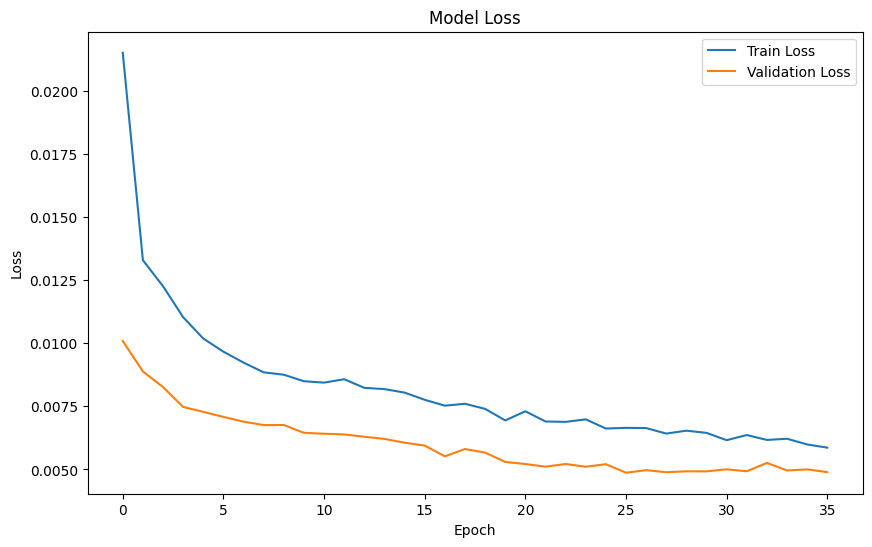

In [9]:
# --- 6. Train the Model ---
# EarlyStopping to stop training when a monitored metric has stopped improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
batch =  8
history = model.fit(X_train, Y_train,
                    epochs=100, # You can increase epochs, EarlyStopping will handle it
                    batch_size= batch ,
                    validation_split=0.2, # Use a portion of training data for validation
                    callbacks=[early_stopping],
                    verbose=1)

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 16, 200)        │       162,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        50,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 637,955 (2.43 MB)

 Trainable params: 212,651 (830.67 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 425,304 (1.62 MB)

In [11]:
# --- 7. Evaluate the Model ---
train_loss = model.evaluate(X_train, Y_train, verbose=0)
test_loss = model.evaluate(X_test, Y_test, verbose=0)
print(f"\nTrain Loss (MSE): {train_loss:.4f}")
print(f"Test Loss (MSE): {test_loss:.4f}")


Train Loss (MSE): 0.0058
Test Loss (MSE): 0.0049


In [12]:
# --- 8. Make Predictions ---
# Make predictions on the test set
Y_pred_scaled = model.predict(X_test)
print(f"\nShape of Y_pred_scaled: {Y_pred_scaled.shape}")
print(f"Shape of Y_test: {Y_test.shape}")
print(f"Shape of X_test: {X_test.shape}")

# Inverse transform the predictions and actual values to the original scale
Y_pred = scaler_target.inverse_transform(Y_pred_scaled)
Y_test_original = scaler_target.inverse_transform(Y_test.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Y_test_original, Y_pred))
print(f"Test RMSE: {rmse:.4f}")

bias =np.mean( Y_pred- Y_test_original)
print(f"Test bias: { bias:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Shape of Y_pred_scaled: (432, 1)
Shape of Y_test: (432,)
Shape of X_test: (432, 16, 2)
Test RMSE: 1.3291
Test bias: 0.0681


In [13]:
#Y_pred
#Y_test_original
#print(Y_pred .shape)
#df_cleaned[train_size:len(Y)]['Date']


#dt_ys = df_cleaned[train_size:len(Y)]#['Date']

print(df_cleaned.tail)
print((len(Y)-Y_test.shape[0]  ))
print(len(Y) )
dt_ys = df_cleaned.iloc[  ( df_cleaned.shape[0]-Y_test.shape[0]  )  : df_cleaned.shape[0] ]#['Date']


print(dt_ys )
dt_ys['Y_pred'] = Y_pred
dt_ys['Y_test_original']= Y_test_original

dt_ys[['Date','Y_pred', 	'Y_test_original']]

dt_ys['Date'] = pd.to_datetime( dt_ys['Date'])

summer_df = dt_ys[ dt_ys['Date'].dt.month.isin([6, 7, 8])]

print(summer_df.tail())

summer_df.to_csv( ( model_site[0] + "summer_df.csv") )

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(summer_df['Y_test_original'], summer_df['Y_pred']))
print(f"Test RMSE: {rmse:.4f}")

<bound method NDFrame.tail of           tmean   site_no       Date  00010_Mean  00060_Mean
5996   0.262210  12305000 2012-03-01    0.185185    0.006544
5997   0.259220  12305000 2012-03-02    0.185185    0.005354
5998   0.412829  12305000 2012-03-03    0.211640    0.005354
5999   0.456446  12305000 2012-03-04    0.264550    0.007337
6000   0.364971  12305000 2012-03-05    0.264550    0.011699
...         ...       ...        ...         ...         ...
10558  0.623564  12305000 2024-08-27    0.724868    0.075550
10559  0.521666  12305000 2024-08-28    0.661376    0.076145
10560  0.658564  12305000 2024-08-29    0.682540    0.076343
10561  0.736381  12305000 2024-08-30    0.735450    0.075749
10562  0.782265  12305000 2024-08-31    0.783069    0.075154

[2174 rows x 5 columns]>
1726
2158
          tmean   site_no       Date  00010_Mean  00060_Mean
9709   0.531151  12305000 2022-05-01    0.328042    0.127503
9710   0.559728  12305000 2022-05-02    0.338624    0.159231
9711   0.585991  12

<ipython-input-13-e1aecc7ee74d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ys['Y_pred'] = Y_pred
<ipython-input-13-e1aecc7ee74d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ys['Y_test_original']= Y_test_original
<ipython-input-13-e1aecc7ee74d>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

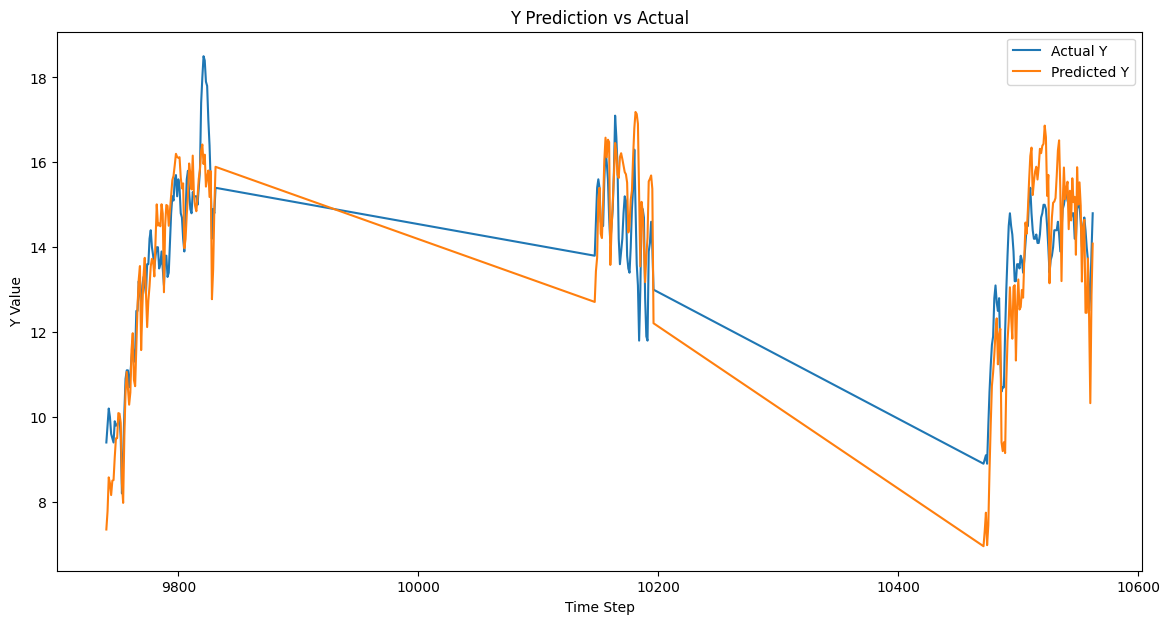

In [14]:
plt.figure(figsize=(14, 7))
plt.plot( summer_df['Y_test_original'], label='Actual Y')
plt.plot( summer_df['Y_pred'], label='Predicted Y')
plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

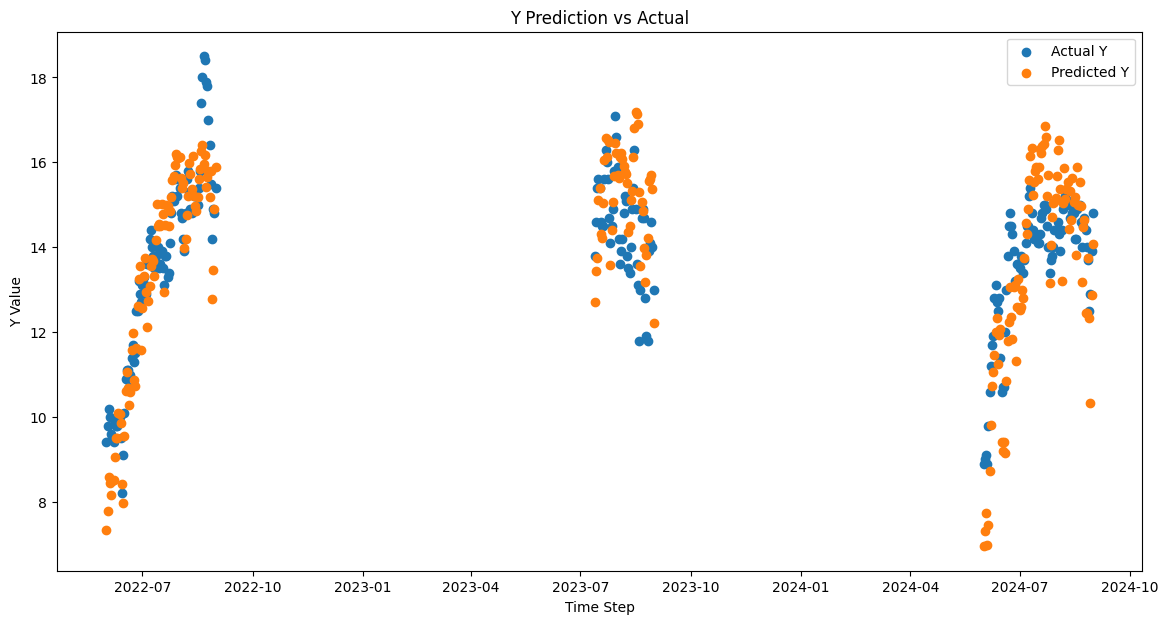

In [15]:
plt.figure(figsize=(14, 7))
plt.scatter(summer_df['Date'], summer_df['Y_test_original'], label='Actual Y')
plt.scatter(summer_df['Date'], summer_df['Y_pred'], label='Predicted Y')



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

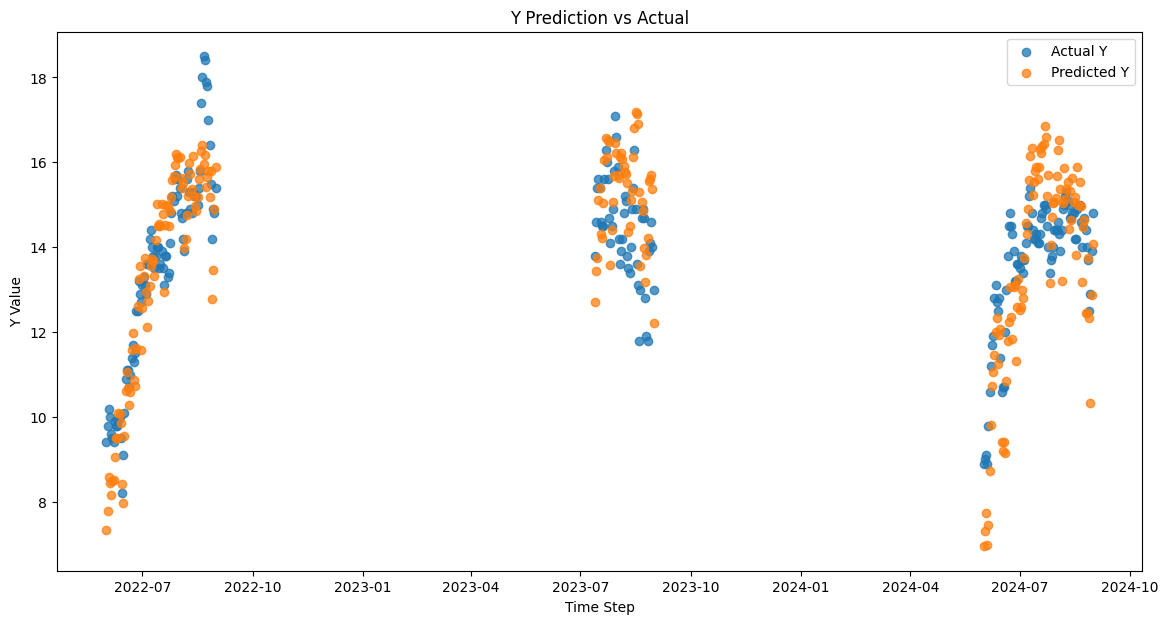

In [16]:
small= summer_df[0:256]
alpha=0.75
plt.figure(figsize=(14, 7))
plt.scatter( small['Date'],  small['Y_test_original'], label='Actual Y',alpha=alpha)
plt.scatter( small['Date'],  small['Y_pred'], label='Predicted Y',alpha=alpha)



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

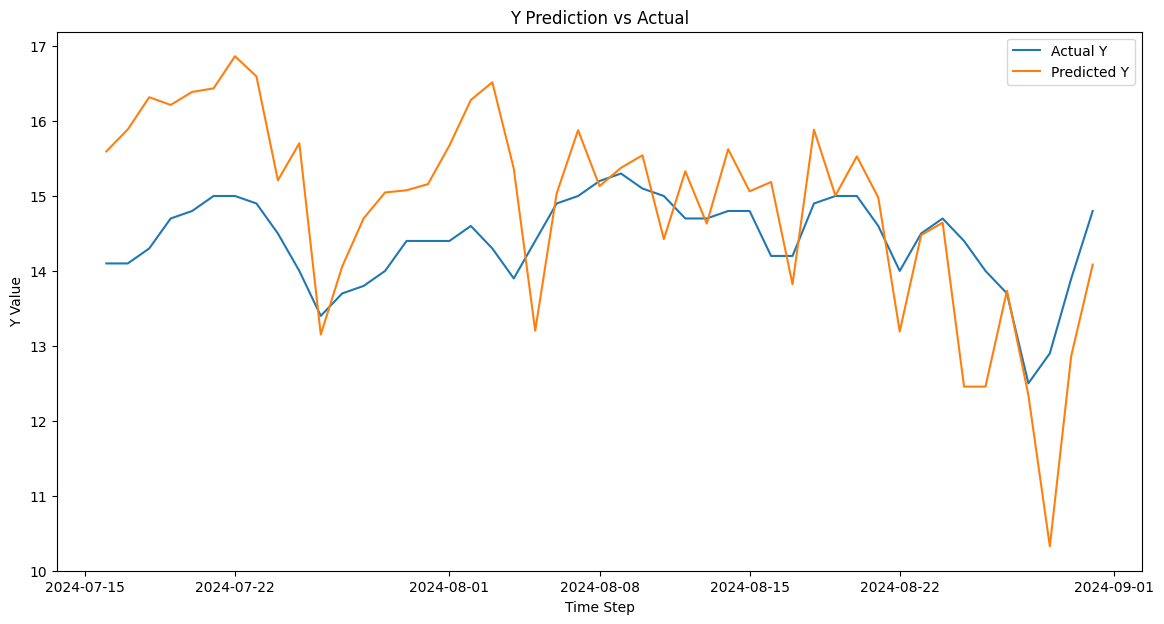

In [17]:
small= summer_df[187:256]

plt.figure(figsize=(14, 7))
plt.plot( small['Date'],  small['Y_test_original'], label='Actual Y')
plt.plot( small['Date'],  small['Y_pred'], label='Predicted Y')



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

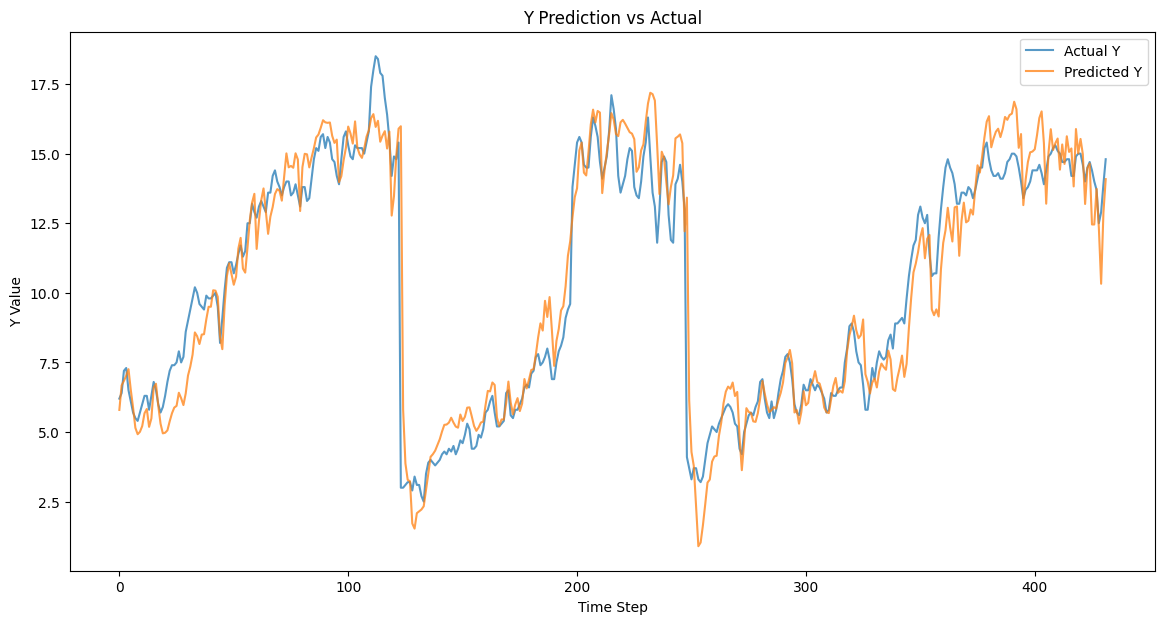

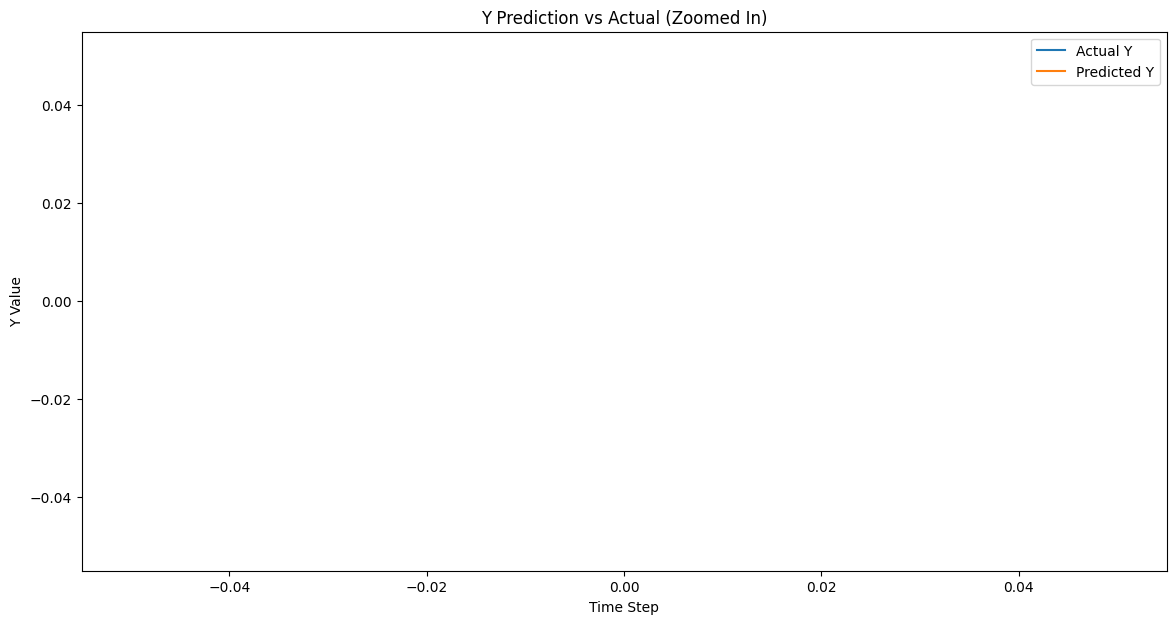

In [18]:



# --- 9. Visualize Predictions vs. Actual ---
plt.figure(figsize=(14, 7))
plt.plot(Y_test_original, label='Actual Y' ,alpha=alpha )
plt.plot(Y_pred, label='Predicted Y' ,alpha=alpha)
plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

# Optional: Plot a smaller segment for better detail
plt.figure(figsize=(14, 7))
plt.plot(Y_test_original[1234:1456], label='Actual Y')
plt.plot(Y_pred[ 1234:1456 ], label='Predicted Y')
plt.title('Y Prediction vs Actual (Zoomed In)')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

In [19]:

#print("h1:", h1)

#print(f"Test RMSE: {rmse:.4f}")



result_df = pd.DataFrame({
    "train_month" : [train_month]
   , "h1":[h1]
                          ,"h2":[h2]
                          ,"d1":[d1]
                          ,"d2":[d2]
                          ,"batch":[batch]
                          ,"look_back":[look_back]


                          ,"optimizer":[optimizer]
    ,'learning_rate':[learning_rate]
                          , "rmse":[rmse]
                           , "bias":[bias]})

print(result_df)


result_df.to_csv( model_site[0]+'_result_df.csv' , index=False)

result_df.to_csv('/content/drive/My Drive/LSTM_results/' + model_site[0]+'_result_df_'+   current_time.strftime("%Y%m%d%H%M") + '.csv' , index=False)


          train_month   h1  h2    d1     d2  batch  look_back  \
0  [3, 4, 5, 6, 7, 8]  200  50  0.05  0.005      8         16   

                                           optimizer  learning_rate      rmse  \
0  <keras.src.optimizers.adam.Adam object at 0x7b...          0.001  1.205027   

      bias  
0  0.06814  


In [20]:
model.save( (model_site[0]+'_lstm_model.h5') )

<ipython-input-21-79d2a3d92a1a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summer_df['bias'] = summer_df['Y_pred'] - summer_df['Y_test_original']


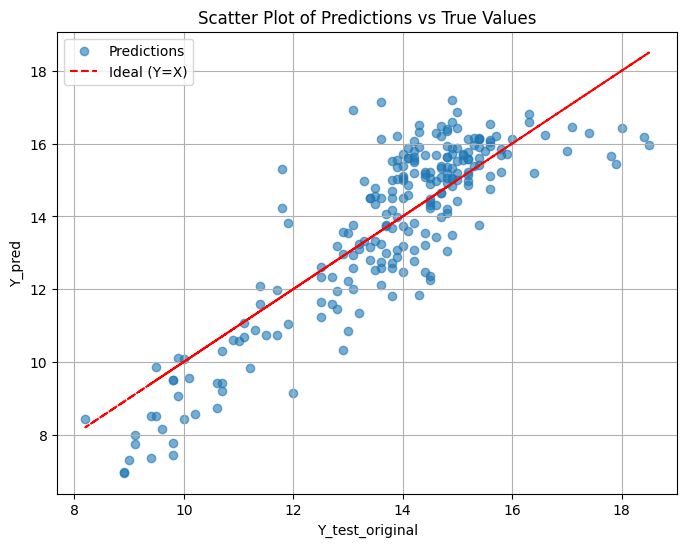

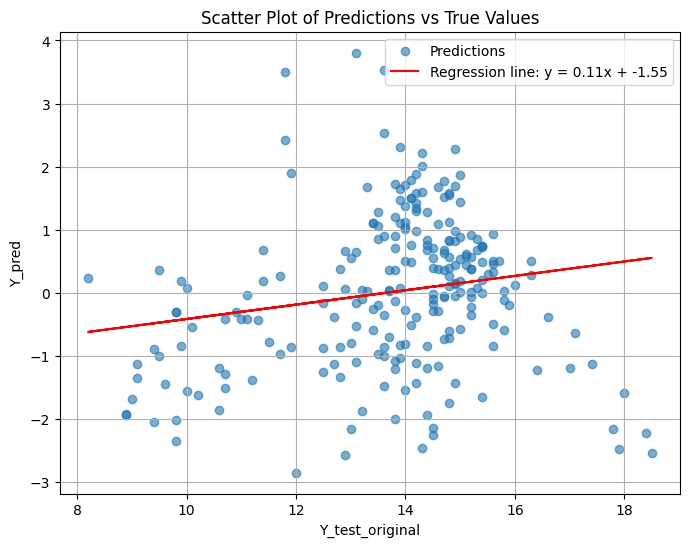

In [21]:
summer_df

# 1. Add a column "bias"
summer_df['bias'] = summer_df['Y_pred'] - summer_df['Y_test_original']

# 2. Scatter plot: x = Y_test_original, y = Y_pred
plt.figure(figsize=(8, 6))
plt.scatter( summer_df['Y_test_original'],  summer_df['Y_pred'], alpha=0.6, label='Predictions')
plt.plot( summer_df['Y_test_original'],  summer_df['Y_test_original'], color='red', linestyle='--', label='Ideal (Y=X)')
plt.xlabel('Y_test_original')
plt.ylabel('Y_pred')
plt.title('Scatter Plot of Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

# 2. Scatter plot: x = Y_test_original, y = Y_pred
plt.figure(figsize=(8, 6))
plt.scatter( summer_df['Y_test_original'],  summer_df['bias'], alpha=0.6, label='Predictions')

# Calculate regression line
coefficients = np.polyfit(  summer_df['Y_test_original'],  summer_df['bias'] , 1)  # 1 for linear regression
polynomial = np.poly1d(coefficients)
y_pred = polynomial(  summer_df['Y_test_original']  )
# Plot regression line
plt.plot(  summer_df['Y_test_original'] , y_pred, color='red', label=f'Regression line: y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}')


plt.xlabel('Y_test_original')
plt.ylabel('Y_pred')
plt.title('Scatter Plot of Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

https://www.sciencedirect.com/science/article/pii/S2214581824000648#sec0030